## DONDERS MML: Multimodal Animations 

### 0. Import Necessary Packages 

In [34]:
import cv2 #opencv
import math #basic operations
import numpy as np #basic operations
import pandas as pd #data wrangling
import csv #csv saving
import os #some basic functions for inspecting folder structure etc.
from os import listdir
from os.path import isfile, join
import glob as glob
import moviepy.editor as mop
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import tkinter # GUI toolkit to open and save files
from tkinter import filedialog, messagebox  # GUI toolkit to open and save files
from scipy.signal import butter, filtfilt, iirnotch
import librosa
import librosa.display
import tempfile
import shutil
import tqdm


print("Everything imported successfully")


Everything imported successfully


### 1. The User Selects their Own Files with a GUI pop-up 

In [16]:
import tkinter as tk
from tkinter import filedialog, messagebox

# Create the GUI window
root = tk.Tk()
root.attributes('-topmost', True)
root.iconify()

# # Pre-announcement message box with bigger font
# messagebox.showinfo("File Selection", "Please select your 2D Videos with annotated 2D tracking. Here we are working with 3 videos in the .mp4 format ", icon='info')
# # Ask the user to select the Files that will be part of the Multimodal Animation
# videos_input_2D = filedialog.askopenfilename(title="Select your 2D Videos with the annotated 2D tracking", filetypes=[("Video Files", "*.mp4")], multiple='True')
# # Convert the tuple returned by askopenfilenames() to a list because we have multipe files 
# videos_input_2D = list(videos_input_2D)
# print('You have selected the following 2D Videos: ' + str(videos_input_2D))


# messagebox.showinfo("File Selection", "Please select your 3D Motion Tracking file. This is .csv file with xyz coordinates for each landmark", icon='info')
# MT_3D_input = filedialog.askopenfilename(title="Select your 3D Motion Tracking file (xyz)", filetypes=[("CSV Files", "*.csv")])
# print('You have selected the following 3D Motion Tracking file: ' + str(MT_3D_input))


# messagebox.showinfo("File Selection", "Please select your audio file. This is a .wav file", icon='info')
# audio_input = filedialog.askopenfilename(title="Select your audio file corresponding to the video", filetypes=[("Audio Files", "*.wav")])
# print('You have selected the following audio file: ' + str(audio_input))


messagebox.showinfo("File Selection", "Please select your PLUX file. This is a .csv file extracted from LSL", icon='info')

PLUX_input = filedialog.askopenfilename(title="Select your PLUX file containing physiological data", filetypes=[("CSV Files", "*.csv")])
print('You have selected the following PLUX file: ' + str(PLUX_input))

root.destroy()


You have selected the following PLUX file: C:/Users/ahmar/OneDrive/Documents/GitHub/Mobile-Multimodal-Lab/2_PREPROCESSING/1_XDF_PROCESSING/data_processed/T1/marker_MULTIPLEpairs/T1_experiment_PLUX_P1_NoVision_Movement_0_StartParticipantSinging_NoVision_Movement_0_EndParticipantSinging.csv


### 2. Create a 3D Animation from the MT_3D_input

Saved the enhanced 3D animation!


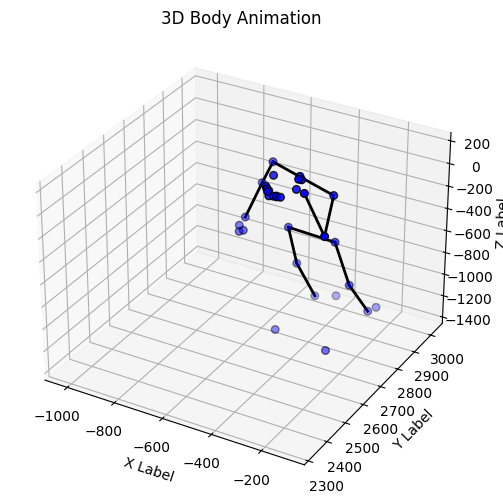

In [3]:
MT_tracking = pd.read_csv(MT_3D_input)

# Create a figure and axis
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Define the number of frames
num_frames = len(MT_tracking)

# Define the scatter plot
scatter = ax.scatter([], [], [], marker='o')


# Defyining Connectsion between landmarks to draw lines fro Example . #Change according to the landmarks in your data
connections = [
    # Head and torso
    ('nose', 'left_eye_inner'), 
    ('nose', 'right_eye_inner'),
    ('left_eye_inner', 'left_eye'), 
    ('left_eye', 'left_eye_outer'),
    ('right_eye_inner', 'right_eye'), 
    ('right_eye', 'right_eye_outer'),
    ('nose', 'left_ear'),
    ('nose', 'right_ear'),
    
    # Upper body (shoulders, arms)
    ('left_shoulder', 'right_shoulder'),
    ('left_shoulder', 'left_elbow'),
    ('left_elbow', 'left_wrist'),
    ('right_shoulder', 'right_elbow'),
    ('right_elbow', 'right_wrist'),
    
    # Lower body (hips, legs)
    ('left_shoulder', 'left_hip'),
    ('right_shoulder', 'right_hip'),
    ('left_hip', 'right_hip'),
    ('left_hip', 'left_knee'),
    ('left_knee', 'left_ankle'),
    ('right_hip', 'right_knee'),
    ('right_knee', 'right_ankle'),
    
    # Feet (toes and heel)
    ('left_ankle', 'left_heel'),
    ('right_ankle', 'right_heel'),
    ('left_heel', 'left_foot_index'),
    ('right_heel', 'right_foot_index'),
    
    # Optional: Left and right wrists to fingers (if available)
    ('left_wrist', 'left_pinky'),
    ('left_wrist', 'left_index'),
    ('left_wrist', 'left_thumb'),
    ('right_wrist', 'right_pinky'),
    ('right_wrist', 'right_index'),
    ('right_wrist', 'right_thumb')
]


# Calculate dynamic axis limits based on actual data ranges
x_min, x_max = MT_tracking.filter(like='_x').min().min(), MT_tracking.filter(like='_x').max().max()
y_min, y_max = MT_tracking.filter(like='_y').min().min(), MT_tracking.filter(like='_y').max().max()
z_min, z_max = MT_tracking.filter(like='_z').min().min(), MT_tracking.filter(like='_z').max().max()


# Enhanced Update function for animation
def update(frame):
    ax.clear()
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title('3D Body Animation')
    
    # Set the limits dynamically
    ax.set_xlim3d(x_min, x_max)
    ax.set_ylim3d(y_min, y_max)
    ax.set_zlim3d(z_min, z_max)

    # Extract the X, Y, and Z coordinates for the current frame
    frame_data = MT_tracking.iloc[frame]
    x = frame_data.filter(like='_x')
    y = frame_data.filter(like='_y')
    z = frame_data.filter(like='_z')

    # Plot the dots (landmarks)
    scatter = ax.scatter(x, y, z, marker='o', color='blue', s=30, edgecolor='k')  # s=30 for larger dots
    
    # Draw lines to connect the landmarks
    for part1, part2 in connections:
        # Get the coordinates for each pair of landmarks to connect
        x_line = [frame_data[part1 + '_x'], frame_data[part2 + '_x']]
        y_line = [frame_data[part1 + '_y'], frame_data[part2 + '_y']]
        z_line = [frame_data[part1 + '_z'], frame_data[part2 + '_z']]
        ax.plot(x_line, y_line, z_line, color='black', linewidth=2)  # Black lines with thickness 2

    return scatter,

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, interval=1000/60)

# Save the animation as a video
output_folder = os.path.abspath('./animation_videos_temp')
output_file = os.path.join(output_folder, '3d_animation.mp4')
os.makedirs(output_folder, exist_ok=True)


# Save the animation
ani.save(output_file, writer='ffmpeg')
print('Saved the enhanced 3D animation!')


## 4. Extract Amplitude Envelope and Plot Audio Signal 

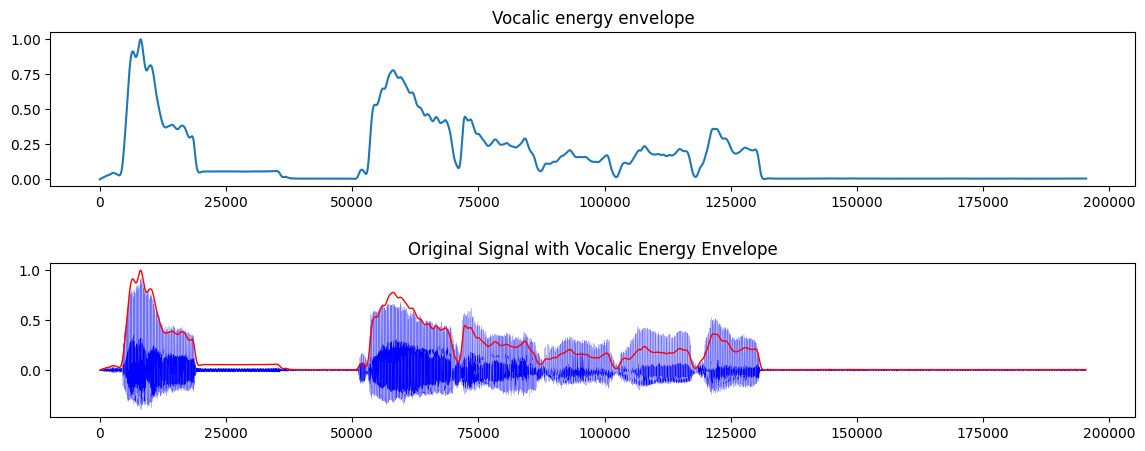

In [20]:
# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Define the lowpass filter
def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to extract amplitude envelope
def amp_envelope(audiofilename):
    # load audio with librosa
    audio, sr = librosa.load(audiofilename, sr=None)
    # Bandpass filter 400-4000Hz
    data = butter_bandpass_filtfilt(audio, 400, 4000, sr, order=2)
    # Lowpass filter 10Hz
    data = butter_lowpass_filtfilt(np.abs(data), 10, sr, order=2)
    # scale from 0 to 1
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data, sr

# Get the amplitude envelope
ampv, sr = amp_envelope(audio_input)
# Plot the filtered signal and the original signal
plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(ampv)
plt.title('Vocalic energy envelope')

# Extract and plot the original signal with the amplitude envelope
rawaudio, sr = librosa.load(audio_input, sr=None)
plt.subplot(2, 1, 2)
plt.plot(rawaudio, label = 'Original Signal', color='blue', linewidth=0.1)
plt.plot(ampv, label='Amplitude Envelope', color='red', linewidth=1)
plt.title('Original Signal with Vocalic Energy Envelope')

plt.subplots_adjust(hspace=0.5)  # Increase the space between subplots to move title down
plt.show()


# Create a Audio DataFrame with time (in secs) raw audio and amplitude envelope for later use
audio_df = pd.DataFrame({'time': np.arange(len(ampv)) / sr, 'audio': rawaudio, 'envelope': ampv})
audio_df.head()


## 5. Filter and Plot Physiological Signal: EMG, ECG and RESP

      LSL_Time  PLUX_P1_nSeq  PLUX_P1_ECG0  PLUX_P1_EMG1  PLUX_P1_EMG2  \
0  6572.678291     1255098.0      -0.05948       0.00159      -0.00518   
1  6572.679291     1255099.0      -0.06500       0.00032      -0.00286   
2  6572.680291     1255100.0      -0.07403       0.00186      -0.00223   
3  6572.681290     1255101.0      -0.08230       0.00091      -0.00223   
4  6572.682290     1255102.0      -0.08432       0.00395      -0.00009   

   PLUX_P1_RESPIRATION3  
0               0.49232  
1               0.49690  
2               0.49072  
3               0.48798  
4               0.49489  
Index(['LSL_Time', 'PLUX_P1_nSeq', 'PLUX_P1_ECG0', 'PLUX_P1_EMG1',
       'PLUX_P1_EMG2', 'PLUX_P1_RESPIRATION3'],
      dtype='object')


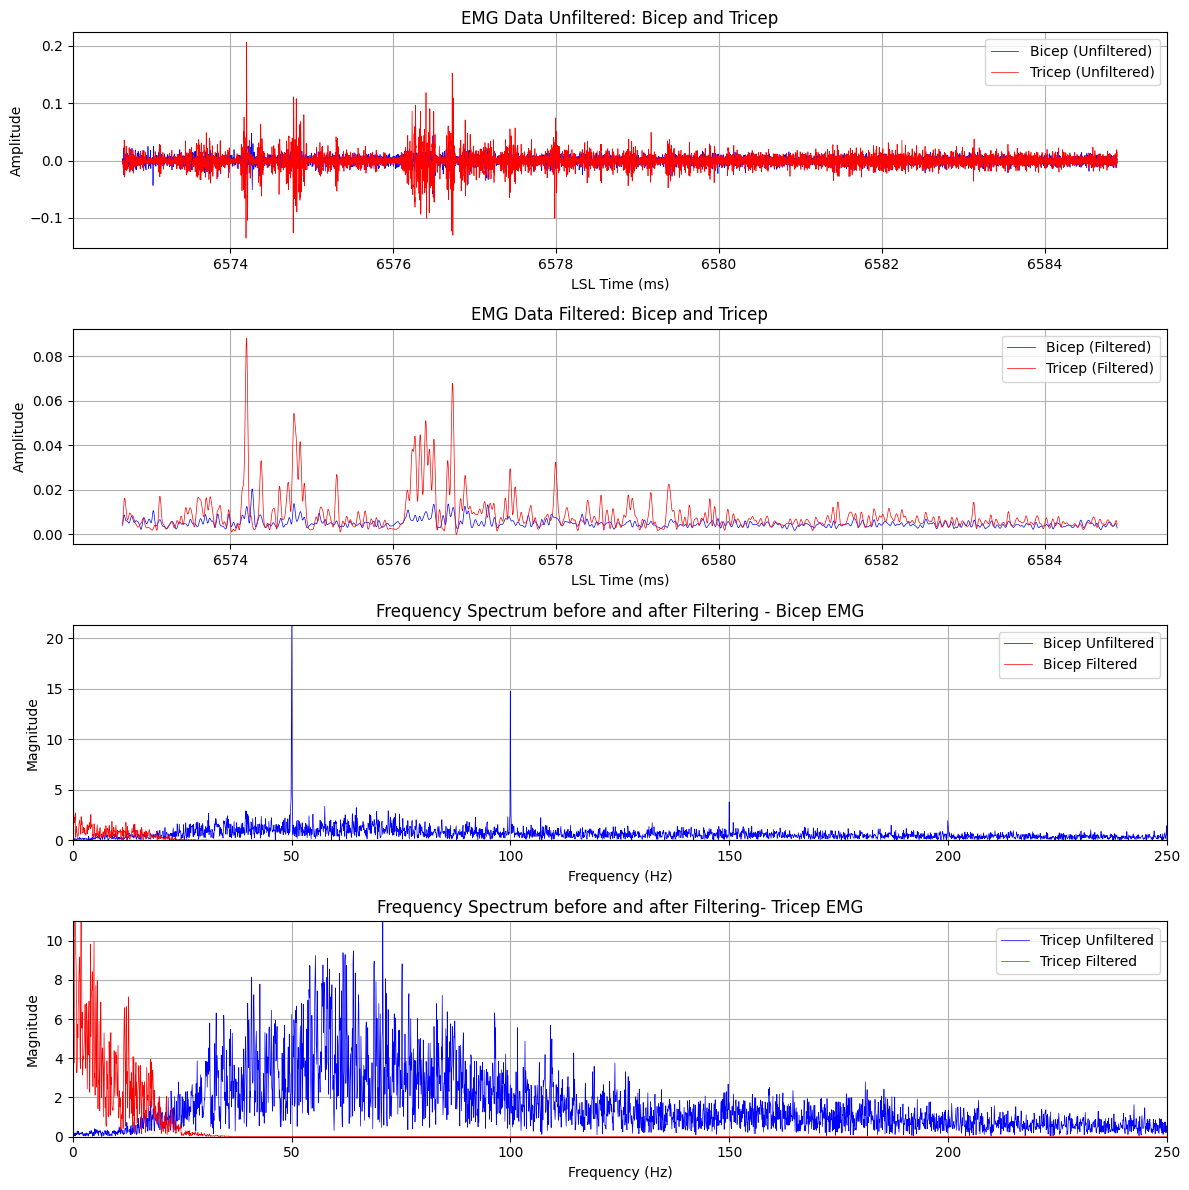

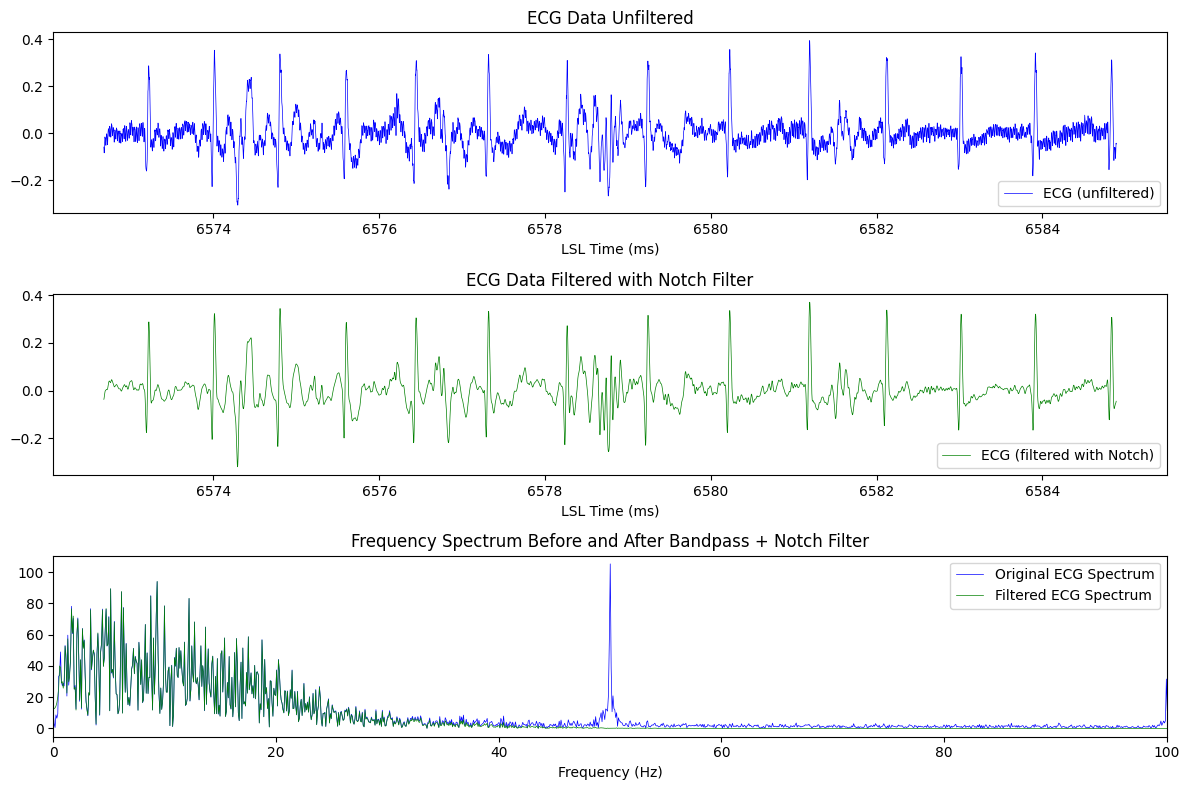

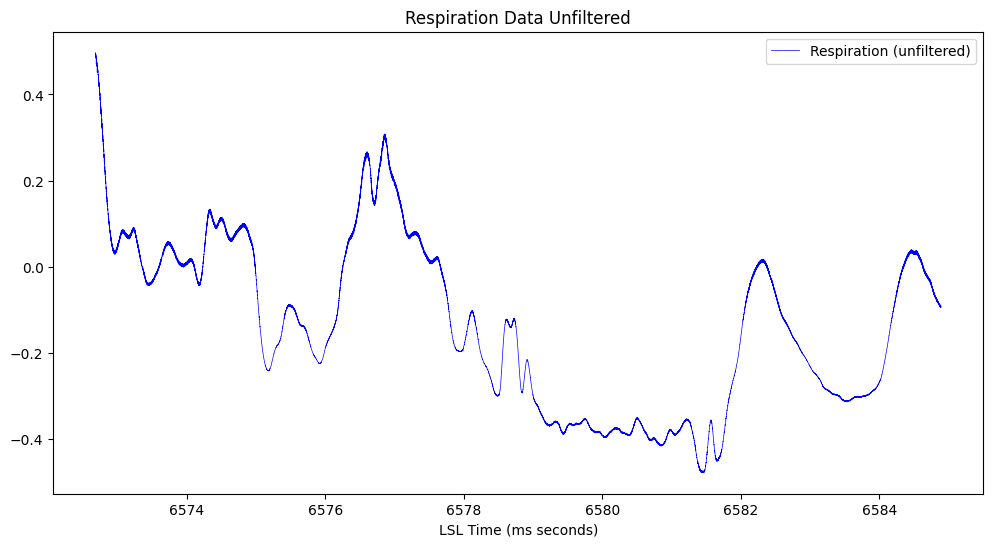

In [33]:
PLUX_data = pd.read_csv(PLUX_input)
print(PLUX_data.head())  # To see the first few rows of the DataFrame
print(PLUX_data.columns)  # To list the column names

sampling_rate = 1000 # Sampling rate of 1000 Hz for our PLUX stream 

## ----------------  1. EMG DATA PROCESSING ---------------- ## 

# Define Butterworth filter function
def butter_filter(data, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    # Apply zero-phase filtering with padding to prevent edge effects
    padded_data = np.pad(data, (1000, 1000), 'edge')
    filtered_data = filtfilt(b, a, padded_data)
    return filtered_data[1000:-1000]  # Remove padding

# High-pass filter, rectify, and then low-pass filter EMG signals
def process_emg(emg_signal, fs, cutoff_high, cutoff_low):
    # Apply high-pass filter
    high_passed = butter_filter(emg_signal, cutoff_high, fs, order=4, filter_type='high')
    # Rectify (full-wave rectification)
    rectified = np.abs(high_passed)
    # Apply low-pass filter
    low_passed = butter_filter(rectified, cutoff_low, fs, order=4, filter_type='low')
    return low_passed

# Your EMG data and sampling rate
EMG_bicep = PLUX_data.iloc[:, 3].values
EMG_tricep = PLUX_data.iloc[:, 4].values
sampling_rate = 1000  # Replace with your actual sampling rate

# Process the EMG data for each muscle
EMG_bicep_processed = process_emg(EMG_bicep, sampling_rate, 2, 20)     # 2 Hz high-pass, 20 Hz low-pass
EMG_tricep_processed = process_emg(EMG_tricep, sampling_rate, 2, 20)   # 2 Hz high-pass, 20 Hz low-pass

# Compute frequency spectra for EMG bicep
freqs_bicep = np.fft.rfftfreq(len(EMG_bicep), d=1/sampling_rate)
fft_bicep = np.abs(np.fft.rfft(EMG_bicep))
fft_bicep_processed = np.abs(np.fft.rfft(EMG_bicep_processed))

# Compute frequency spectra for EMG tricep
freqs_tricep = np.fft.rfftfreq(len(EMG_tricep), d=1/sampling_rate)
fft_tricep = np.abs(np.fft.rfft(EMG_tricep))
fft_tricep_processed = np.abs(np.fft.rfft(EMG_tricep_processed))

# Visualization: Create a figure with 4 subplots
plt.figure(figsize=(12, 12))

# Subplot 1: Time-domain EMG data before filtering
plt.subplot(4, 1, 1)
plt.plot(PLUX_data['LSL_Time'], EMG_bicep, label='Bicep (Unfiltered)', color='blue', linewidth=0.5)
plt.plot(PLUX_data['LSL_Time'], EMG_tricep, label='Tricep (Unfiltered)', color='red', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.ylabel('Amplitude')
plt.title('EMG Data Unfiltered: Bicep and Tricep')
plt.grid(True)

# Subplot 2: Time-domain EMG data after filtering
plt.subplot(4, 1, 2)
plt.plot(PLUX_data['LSL_Time'], EMG_bicep_processed, label='Bicep (Filtered)', color='blue', linewidth=0.5)
plt.plot(PLUX_data['LSL_Time'], EMG_tricep_processed, label='Tricep (Filtered)', color='red', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.ylabel('Amplitude')
plt.title('EMG Data Filtered: Bicep and Tricep')
plt.grid(True)

# Subplot 3: Frequency spectrum for Bicep EMG
plt.subplot(4, 1, 3)
plt.plot(freqs_bicep, fft_bicep, label='Bicep Unfiltered', color='blue', linewidth=0.5)
plt.plot(freqs_bicep, fft_bicep_processed, label='Bicep Filtered', color='red', linewidth=0.5)
plt.xlim(0, 250)  # Adjust frequency range as needed
plt.ylim(0, max(fft_bicep))  # Adjust y-axis limits as needed
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum before and after Filtering - Bicep EMG')
plt.grid(True)

# Subplot 4: Frequency spectrum for Tricep EMG
plt.subplot(4, 1, 4)
plt.plot(freqs_tricep, fft_tricep, label='Tricep Unfiltered', color='blue', linewidth=0.5)
plt.plot(freqs_tricep, fft_tricep_processed, label='Tricep Filtered', color='red', linewidth=0.5)
plt.xlim(0, 250)
plt.ylim(0, max(fft_tricep))  # Adjust y-axis limits as needed
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum before and after Filtering- Tricep EMG')
plt.grid(True)

plt.tight_layout()
plt.show()

# Create a new ECG DataFrame with time (in secs) and the processed EMG signal for Bicep and Tricep
EMG_df = pd.DataFrame({'time': PLUX_data['LSL_Time'] / 1000, 'EMG_bicep': EMG_bicep_processed, 'EMG_tricep': EMG_tricep_processed})




## ----------------  2. ECG DATA PROCESSING ---------------- ##

# Define the notch filter function to remove powerline interference
def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    b, a = iirnotch(notch_freq / (fs / 2), quality_factor)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Updated ECG processing function with notch filter
def process_ecg(ecg_signal, fs, cutoff_high, cutoff_low, notch_freq, quality_factor):
    # Apply high-pass filter
    high_passed = butter_filter(ecg_signal, cutoff_high, fs, order=4, filter_type='high')
    # Apply low-pass filter
    low_passed = butter_filter(high_passed, cutoff_low, fs, order=4, filter_type='low')
    # Apply notch filter
    filtered = notch_filter(low_passed, fs, notch_freq, quality_factor)
    return filtered

# Your ECG data and sampling rate
ECG = PLUX_data.iloc[:,2]

# Process the ECG signal with the notch filter
ECG_processed = process_ecg(ECG, sampling_rate, 0.5, 40, 50, 30)  # 0.5 Hz high-pass, 40 Hz low-pass, 50 Hz notch, 30 Q-factor


# Visualtiation with matplotlib: ECG data before and after filtering + Furier Transform frequency (3 subplots)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(PLUX_data['LSL_Time'], ECG, label='ECG (unfiltered)', color='blue', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.title('ECG Data Unfiltered')

plt.subplot(3, 1, 2)
plt.plot(PLUX_data['LSL_Time'], ECG_processed, label='ECG (filtered with Notch)', color='green', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.title('ECG Data Filtered with Notch Filter')

# Optional: Plot frequency spectrum to visualize the effect of the notch filter
freqs = np.fft.rfftfreq(len(ECG), d=1/sampling_rate)
fft_ecg = np.abs(np.fft.rfft(ECG))
fft_ecg_processed = np.abs(np.fft.rfft(ECG_processed))

plt.subplot(3, 1, 3)
plt.plot(freqs, fft_ecg, label='Original ECG Spectrum', color='blue', linewidth=0.5)
plt.plot(freqs, fft_ecg_processed, label='Filtered ECG Spectrum', color='green', linewidth=0.5)
plt.xlim(0, 100)  # Focus on frequencies up to 100 Hz
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Spectrum Before and After Bandpass + Notch Filter')

plt.tight_layout()
plt.show()


## Create a new ECG DataFrame with time (in secs) and the processed ECG signal
ECG_df = pd.DataFrame({'time': PLUX_data['LSL_Time'] / 1000, 'ECG': ECG_processed})



## ----------------  3. RESPIRATION DATA PROCESSING ---------------- ##

RSP = PLUX_data.iloc[:,5]


# visualtiation with matplotlib: Unfiltered respiration data
plt.figure(figsize=(12, 6))
plt.plot(PLUX_data['LSL_Time'], RSP, label='Respiration (unfiltered)', color='blue', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms seconds)')
plt.title('Respiration Data Unfiltered')
plt.show()

# Create a new Respiration DataFrame with time (in secs) and the raw respiration signal
RSP_df = pd.DataFrame({'time': PLUX_data['LSL_Time'] / 1000, 'RSP': RSP})



## 5. Create the Multimodal Animation 

In [ ]:
# what is the window size in seconds
window = 4


def plot_multimodal(audio, emg, ecg, resp, midpoint):
    # Temporary folder for saving the plot
    tempfolder = tempfile.mkdtemp()

    # Create 5 subplots for the different data streams
    fig, ax = plt.subplots(5, 1, figsize=(14, 20))  # 5 rows (for audio, body, EMG, ECG, and RESP)

    # Define the time window for all plots
    start = midpoint - window / 2
    end = midpoint + window / 2

    # Recenter time for all datasets around the midpoint
    audio['time'] -= midpoint
    emg['time'] -= midpoint
    ecg['time'] -= midpoint
    resp['time'] -= midpoint

    # Plot 1: Audio envelope
    ax[0].plot(audio['time'], audio['audio'], label='Raw Audio', linewidth=0.5)
    ax[0].plot(audio['time'], audio['envelope'], label='Envelope', linewidth=8)
    ax[0].set_xlim(-window / 2, window / 2)
    ax[0].set_ylim(-1, 1)  # Adjust as needed based on your signal
    ax[0].legend(prop={'size': 16})
    ax[0].set_ylabel('Audio')

    # Plot 3: Filtered EMG signal
    ax[2].plot(emg['time'], emg['emg_bicep'], label='EMG Bicep', color='green', linewidth=2)
    ax[2].plot(emg['time'], emg['emg_tricep'], label='EMG Tricep', color='red', linewidth=2)
    ax[2].set_xlim(-window / 2, window / 2)
    ax[2].set_ylim(0, 1)  # Adjust this based on your EMG signal range
    ax[2].legend(prop={'size': 16})
    ax[2].set_ylabel('EMG Signal')

    # Plot 4: Filtered ECG signal
    ax[3].plot(ecg['time'], ecg['ecg'], label='ECG Signal', color='blue', linewidth=2)
    ax[3].set_xlim(-window / 2, window / 2)
    ax[3].set_ylim(-0.5, 0.5)  # Adjust the range based on the filtered ECG
    ax[3].legend(prop={'size': 16})
    ax[3].set_ylabel('ECG')

    # Plot 5: Respiratory signal
    ax[4].plot(resp['time'], resp['resp'], label='Respiration', color='orange', linewidth=2)
    ax[4].set_xlim(-window / 2, window / 2)
    ax[4].set_ylim(-1, 1)  # Adjust based on the range of your RESP data
    ax[4].legend(prop={'size': 16})
    ax[4].set_ylabel('Respiration')
    ax[4].set_xlabel('Time (s)')

    # Apply tight layout and save plot
    plt.tight_layout()
    tpf = tempfolder + '/tempfig.png'
    plt.savefig(tpf)
    plt.close()

    # Load and return the image as a frame for the video
    img = cv2.imread(tpf)
    shutil.rmtree(tempfolder)
    return img



# Function to load and process the video with multimodal data
def process_video_with_multimodal(videofilename, audio, emg, ecg, resp, output_filename):
    # Load the video
    capture = cv2.VideoCapture(videofilename)
    fps = capture.get(cv2.CAP_PROP_FPS)  # Get frames per second
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))  # Width of the frame
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Height of the frame

    # Set up video writer for the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height * 2))  # Double height for plots below video

    # Loop through video frames
    frame_number = 0
    for i in tqdm.tqdm(range(frame_count)):
        ret, frame = capture.read()
        if not ret:
            break  # Break loop if no more frames are available
        
        # Calculate the midpoint (current time in seconds)
        midpoint = frame_number / fps
        
        # Generate the multimodal plot for the current window
        multimodal_img = plot_multimodal(audio, emg, ecg, resp, midpoint)
        
        # Resize the plot to match the video frame width (concatenate vertically)
        multimodal_img = cv2.resize(multimodal_img, (frame_width, frame_height))
        
        # Combine the video frame and the plot vertically
        combined_frame = np.concatenate((frame, multimodal_img), axis=0)  # Stack the video frame and plot vertically
        
        # Write the combined frame to the output video
        out.write(combined_frame)
        
        # Increment frame number
        frame_number += 1
    
    # Release video objects
    capture.release()
    out.release()
    cv2.destroyAllWindows()


process_video_with_multimodal(, audio, emg, ecg, resp, output_filename)



